In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.display import clear_output # очистка вывода в ячейке
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
import tensorflow as tf           # библиотека машинного обучения
# отрисовка прохождения цикла
from tqdm.notebook import tqdm
import gc

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
from datetime import datetime

# Подозрение что дата прасится некоректно, добавим функцию для правильного распознование дат.
def date_parser(date_string):
    return datetime.strptime(date_string, '%d.%m.%Y')

In [34]:
# Загрузка данных
# df = pd.read_csv('/content/drive/MyDrive/RAN_STAJIROVKA/data3.csv', sep=";", index_col='T', parse_dates=True, date_parser=date_parser)
data = pd.read_csv('/content/drive/MyDrive/RAN_STAJIROVKA/Обраб_Сводная_База_МЭП_DIMAR.csv', sep=";", index_col='T', parse_dates=True, date_parser=date_parser)

data = data.replace(",", ".", regex=True)
data = data.dropna()
# #Z98 - нужно исключить - ВВП в текущих, млрд. руб. (2 вариант)
# data = df.drop(columns='Z98')
data = data.drop(columns='Mon')
data = data.apply(pd.to_numeric, errors='coerce')

data['Y2'] = (data['Y2'] + 100) / 100

data.head(5)

,Y1,Y2,X1,X2,X3,X4,X5,X6,X7,X9,...,Z30,Z32,Z50,Z60,Z62,Z63,Z73,Z88,Z98,Z99
T,,,,,,,,,,,,,,,,,,,,,
1999-01-01,300.333333,1.0838,96.5,454,1697.0,2566,283.3,28.5,14.1,101.700,...,108.4,96.92,84.00,277.7,67.0,177.3,1.825465,28.7,300.333333,290.23
1999-02-01,300.333333,1.0413,97.2,472,1832.0,2418,258.8,31.8,16.3,112.014,...,104.1,103.24,85.15,252.1,70.0,179.9,1.895853,29.5,300.333333,290.23
1999-03-01,300.333333,1.0279,97.7,501,2317.0,2532,299.2,36.5,20.5,140.244,...,102.8,107.58,122.00,291.4,93.5,181.2,2.366505,32.4,300.333333,290.23
1999-04-01,367.333333,1.0303,99.1,448,3066.0,2764,283.8,36.9,19.6,159.918,...,103.0,113.06,181.50,277.1,110.8,181.0,3.233398,32.7,367.333333,290.23
1999-05-01,367.333333,1.0222,100.1,414,3607.0,3087,289.1,41.4,22.0,124.644,...,102.2,116.71,221.00,282.1,128.8,179.8,2.198301,32.8,367.333333,290.23


#8.Модель на базе нейронной сети

##8.1  LSTM Совместная модель на два выхода для ВВП и инфляции

In [35]:
# Варианты функций для подготовки обучаещго датасета
# Преобразование данных в окна временных рядов
def _create_dataset(datasetX,datasetY, window_size=12):
    dataX, dataY = [], []
    for i in range(len(datasetX) - window_size):
        #dataX.append(dataset[i:(i + window_size), 1:])
        dataX.append(datasetX[i:(i + window_size), :])
        dataY.append(datasetY[i:(i + window_size), :])
        #dataY.append(datasetY[i + window_size, :])
    return np.array(dataX), np.array(dataY)

def create_dataset(X, y, window_size=1):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size), :])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

def create_dataset_multi_step(X, y, window_size, steps_ahead):
    X_data, y_data = [], []
    for i in range(len(X) - window_size - steps_ahead ):
        X_data.append(X[i:i + window_size])
        y_data.append(y[i+1+ window_size: i+1 + window_size + steps_ahead])
    return np.array(X_data), np.array(y_data)



In [36]:
# Создание классов для масштабирование данных
#scaler = MinMaxScaler()
scalerX = StandardScaler()
scalerY = StandardScaler()


In [37]:
Nparam = 91
#Xin = data.iloc[:, 2:Nparam]  # Входящие данные для ВВП
#Xin = data.iloc[:, :]  # Входящие данные для ВВП . Включим в X сами значения прогнозируемых параметров
Xin = data.iloc[:, :Nparam]  # Входящие данные для ВВП . Включим в X сами значения прогнозируемых параметров
yin = data.iloc[:, 0:2]  # Целевой столбец 2 и 3 ВВП

# Масштабирование данных
scaled_dataX = scalerX.fit_transform(Xin)
scaled_dataY = scalerY.fit_transform(yin)

# Создайте переменную timestamps с временными метками
timestamps = data.index

# Разделите данные и временные метки на обучающие, валидационные и тестовые выборки
X_train_temp, X_temp, y_train_temp, y_temp, index_train_temp, index_temp = train_test_split(
    scaled_dataX, scaled_dataY, timestamps, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test, timestamp_index_val, timestamp_index_test = train_test_split(
    X_temp, y_temp, index_temp, test_size=0.5, shuffle=False)

# Создание датафреймов для обучающей, валидационной и тестовой выборок с учетом временных меток
train_df = pd.DataFrame(y_train_temp, index=index_train_temp, columns=['Y1', 'Y2'])
val_df = pd.DataFrame(y_val, index=timestamp_index_val, columns=['Y1', 'Y2'])
test_df = pd.DataFrame(y_test, index=timestamp_index_test, columns=['Y1', 'Y2'])

train_df_x = pd.DataFrame(X_train_temp, index=index_train_temp, columns=Xin.columns)
val_df_x = pd.DataFrame(X_val, index=timestamp_index_val, columns=Xin.columns)
test_df_x = pd.DataFrame(X_test, index=timestamp_index_test, columns=Xin.columns)

In [38]:
# Выведем полученные датафреймы
print("Train DataFrame:\n", train_df.head(), train_df_x.head())
print("\nValidation DataFrame:\n", val_df.head(), val_df_x.head())
print("\nTest DataFrame:\n", test_df.head(), test_df_x.head())


Train DataFrame:
                   Y1        Y2
T                             
1999-01-01 -1.319890  8.164645
1999-02-01 -1.319890  3.555511
1999-03-01 -1.319890  2.102278
1999-04-01 -1.300606  2.362558
1999-05-01 -1.300606  1.484111                   Y1        Y2        X1        X2        X3        X4  \
T                                                                        
1999-01-01 -1.319890  8.164645 -0.939818 -1.357750 -1.503703 -1.868738   
1999-02-01 -1.319890  3.555511 -0.836161 -1.305359 -1.286602 -2.219551   
1999-03-01 -1.319890  2.102278 -0.762120 -1.220952 -0.506647 -1.949330   
1999-04-01 -1.300606  2.362558 -0.554806 -1.375213  0.697860 -1.399408   
1999-05-01 -1.300606  1.484111 -0.406725 -1.474173  1.567871 -0.633782   

                  X5        X6        X7        X9  ...       Z30       Z32  \
T                                                   ...                       
1999-01-01 -2.182668 -1.131643 -1.224605 -1.293148  ...  8.188601  4.532337   
1999-02-0

In [39]:
print(train_df.shape, val_df.shape, test_df.shape)
print(train_df_x.shape, val_df_x.shape, test_df_x.shape)

(230, 2) (29, 2) (29, 2)
(230, 60) (29, 60) (29, 60)


In [40]:
window_size = 12
steps_ahead = 3

X, y = create_dataset_multi_step(scaled_dataX, scaled_dataY, window_size, steps_ahead)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


# СЕТЬ

In [41]:
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, LayerNormalization, BatchNormalization, GlobalAveragePooling1D, Flatten, Concatenate, Reshape
from tensorflow.keras.models import Model

# Input Layer
input_layer = Input(shape=(window_size, X_train.shape[2]))

# Layers 1-5
x = Dense(64)(input_layer)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = Dropout(0.2)(x)
x = Activation('relu')(x)

# Layers 6-7
x1 = Dense(8)(x)
x2 = Dense(16)(x)

# Layer 8
x1 = LayerNormalization()(x1)

# Layers 9-12
x2 = Dense(128)(x2)
x1 = Activation('relu')(x1)
x2 = Activation('relu')(x2)

# Layers 13-15
x3 = Dense(16)(x)
x4 = Dense(64)(x)
x5 = Dense(128)(x)

# Layer 16
x1 = BatchNormalization()(x1)

# Layer 17
x6 = Dense(128)(x)

# Layers 18-20
x2_flat = GlobalAveragePooling1D()(x2)
x3_flat = Flatten()(x3)

# Layers 21-23
x1_avg = GlobalAveragePooling1D()(x1)
x4_avg = GlobalAveragePooling1D()(x4)
x5_avg = GlobalAveragePooling1D()(x5)

# Layer 24
x1_flat = Flatten()(x1)

# Layer 25
x6_avg = GlobalAveragePooling1D()(x6)

# Layer 26
concat_layer = Concatenate()([x2_flat, x3_flat, x1_avg, x4_avg, x5_avg, x1_flat, x6_avg])

# Layer 27
reshaped_layer = Reshape((12, 62))(concat_layer)

# Layers 28-29
x7 = Dense(16)(reshaped_layer)
x8 = Dense(64)(reshaped_layer)

# Layers 30-32
x7_flat = Flatten()(x7)
reshaped_layer_avg = GlobalAveragePooling1D()(reshaped_layer)
x8_avg = GlobalAveragePooling1D()(x8)

# Layer 33
concat_layer_2 = Concatenate()([x7_flat, reshaped_layer_avg, x8_avg])

# Layer 34
reshaped_layer_2 = Reshape((6, 53))(concat_layer_2)

# Layer 35
x9 = Dense(128)(reshaped_layer_2)

# Layer 36
x9_flat = Flatten()(x9)

# Layer 37
concat_layer_3 = Concatenate()([x9_flat])

# Layer 38
reshaped_layer_3 = Reshape((24, 32))(concat_layer_3)

# Layer 39
reshaped_layer_avg_2 = GlobalAveragePooling1D()(reshaped_layer)

# Layer 40
reshaped_layer_2_flat = Flatten()(reshaped_layer_2)

# Layer 41
reshaped_layer_3_flat = Flatten()(reshaped_layer_3)

# Layer 42
concat_layer_4 = Concatenate()([reshaped_layer_avg_2, reshaped_layer_2_flat, reshaped_layer_3_flat])

# Layer 43
x_avg = GlobalAveragePooling1D()(x)

# Layer 44
concat_layer_4_flat = Flatten()(concat_layer_4)

# Layer 45
concat_layer_5 = Concatenate()([x_avg, concat_layer_4_flat])

# Output Layer
output_layer = Dense(steps_ahead * 2)(concat_layer_5)
reshaped_output = Reshape((steps_ahead, 2))(output_layer)

# Create Model
model = Model(inputs=input_layer, outputs=reshaped_output)

In [42]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
# очистка ОЗУ 
clear_ozu = GarbageCollectorCallback()

In [43]:
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.MSE
model.compile(optimizer = optimizer, loss = loss)

# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8, 
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)


# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=17,
    mode='min',
    restore_best_weights=True)

In [44]:
from time import time
start = time()
# обучение модели вашей
history = model.fit(X_train, y_train,                  # генератор данных для обучения
                          validation_data=(X_val, y_val), # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, reduce_lr, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
7/7 [==============================] - 3s 135ms/step - loss: 0.5759 - val_loss: 0.1735 - lr: 0.0010
Epoch 2/150
7/7 [==============================] - 0s 48ms/step - loss: 0.3244 - val_loss: 0.1752 - lr: 0.0010
Epoch 3/150
7/7 [==============================] - 0s 53ms/step - loss: 0.2603 - val_loss: 0.1205 - lr: 0.0010
Epoch 4/150
7/7 [==============================] - 0s 48ms/step - loss: 0.1966 - val_loss: 0.0826 - lr: 0.0010
Epoch 5/150
7/7 [==============================] - 0s 50ms/step - loss: 0.1716 - val_loss: 0.0802 - lr: 0.0010
Epoch 6/150
7/7 [==============================] - 0s 50ms/step - loss: 0.1612 - val_loss: 0.1113 - lr: 0.0010
Epoch 7/150
7/7 [==============================] - 0s 49ms/step - loss: 0.1471 - val_loss: 0.0752 - lr: 0.0010
Epoch 8/150
7/7 [==============================] - 0s 48ms/step - loss: 0.1300 - val_loss: 0.0718 - lr: 0.0010
Epoch 9/150
7/7 [==============================] - 0s 49ms/step - loss: 0.1174 - val_loss: 0.0906 - lr: 0.0010


In [45]:
# Запрашиваем разрешение пользователя на сохранение модели на диска
user_input = input("Выполнить копирование модели в Google Drive? (y/n): ")

# Если пользователь вводит "y" или "Y", копируем файл
if user_input.lower() == "y":
    !cp /content/best_model.h5 drive/MyDrive/Стажировка_РАН/best_model_0_109.h5
    print("Модель успешно скопирована.")
else:
    print("Копирование модели отменено.")

Выполнить копирование модели в Google Drive? (y/n): n
Копирование модели отменено.


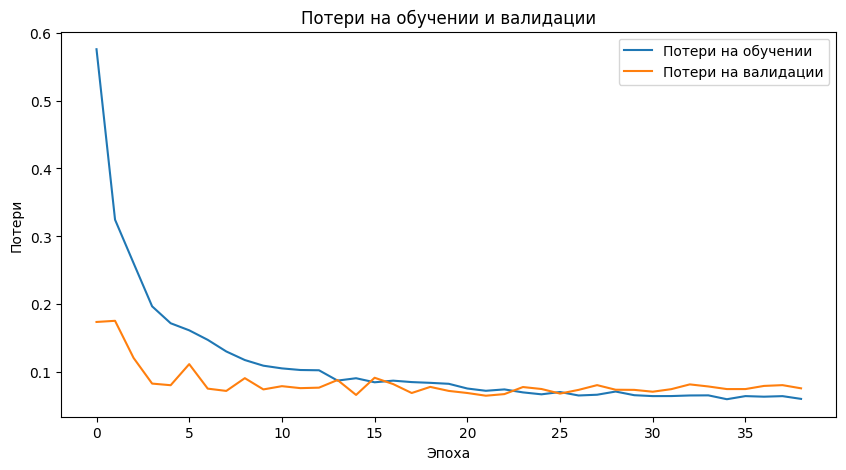

In [46]:
# Вывод графика результатов обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.title('Потери на обучении и валидации')
plt.show()

1/1 [==============================] - 0s 24ms/step


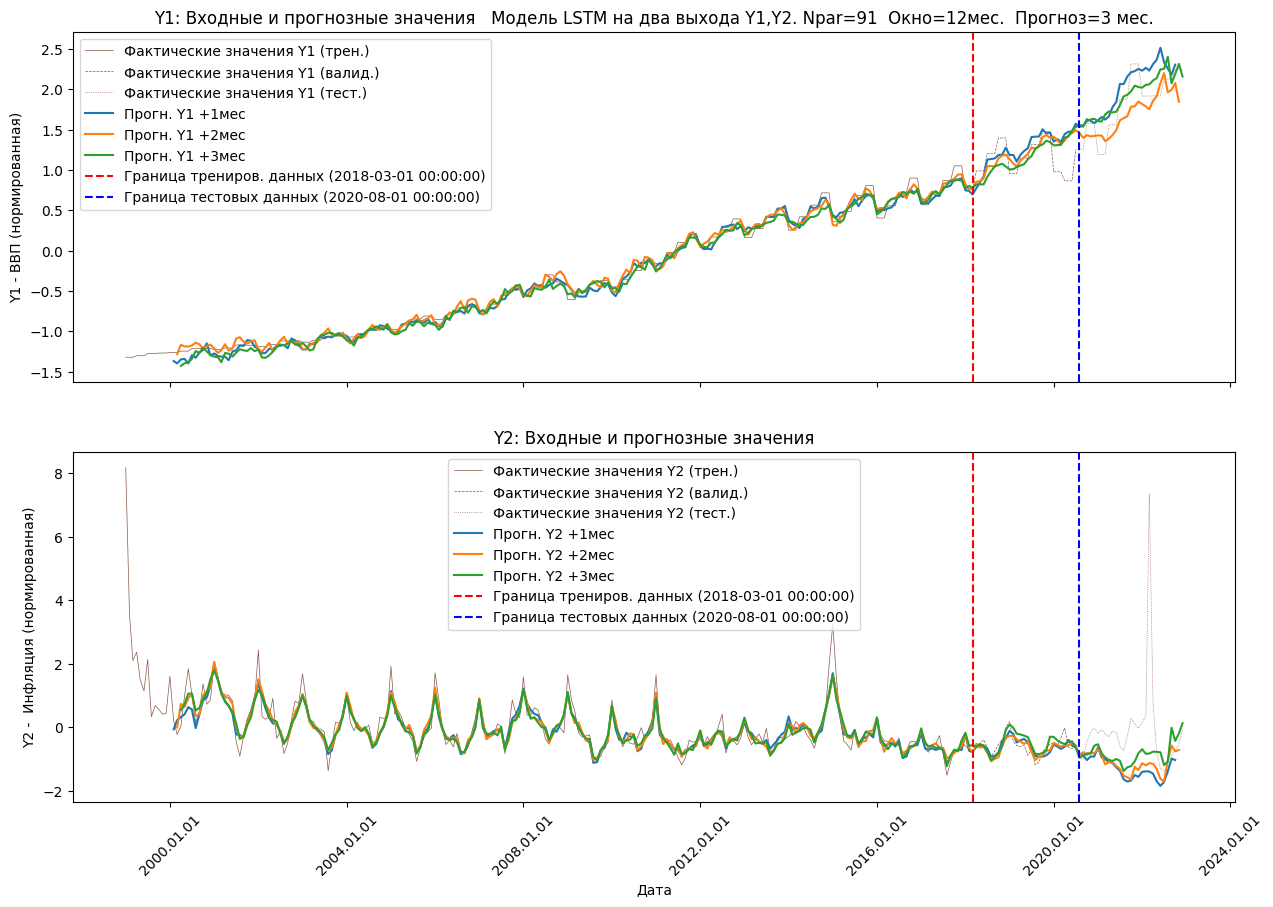

In [47]:
#"Графики прогнозов"

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_multistep(model, X_input):
    predictions = model.predict(X_input[np.newaxis, ...])
    return predictions[0].reshape(-1, 2)

# Объедините все массивы временных меток и данные Y
# timestamps   - временные метки всего массива
# Создайте переменную timestamps с временными метками только для данных X
#timestamps = timestamps[:len(X)]
#all_Y = np.concatenate((y_train_temp, y_val, y_test))

# Получить прогнозы для всех данных
all_predictions = np.array([predict_multistep(model, x) for x in X])

# Разделить прогнозы на Y1 и Y2
predicted_Y1 = all_predictions[:, :, 0]
predicted_Y2 = all_predictions[:, :, 1]

# Разделить истинные значения на Y1 и Y2
true_Y1 = y[:,:, 0]
true_Y2 = y[:,:, 1]

# Создать график
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
#ax1.plot(timestamps[window_size+1:-2], true_Y1[:,0],linestyle='dotted', label='True Y1')
ax1.plot(train_df.index, train_df['Y1'],linewidth=0.5, color=color, label='Фактические значения Y1 (трен.)')
ax1.plot(val_df.index, val_df['Y1'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y1 (валид.)')
ax1.plot(test_df.index, test_df['Y1'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y1 (тест.)')

ax1.plot(timestamps[window_size+1:-2], predicted_Y1[:,0], label='Прогн. Y1 +1мес')
ax1.plot(timestamps[window_size+2:-1], predicted_Y1[:,1], label='Прогн. Y1 +2мес')
ax1.plot(timestamps[window_size+3:], predicted_Y1[:,2], label='Прогн. Y1 +3мес')
ax1.set_title(f'Y1: Входные и прогнозные значения   Модель LSTM на два выхода Y1,Y2. Npar={Nparam}  Окно={window_size}мес.  Прогноз={steps_ahead} мес.')
 
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax1.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax1.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax1.legend()
ax1.set_ylabel("Y1 - ВВП (нормированная)")
# График истинных значений и прогнозов для Y2
# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
ax2.plot(train_df.index, train_df['Y2'],linewidth=0.5, color=color, label='Фактические значения Y2 (трен.)')
ax2.plot(val_df.index, val_df['Y2'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y2 (валид.)')
ax2.plot(test_df.index, test_df['Y2'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y2 (тест.)')

#ax2.plot(timestamps[window_size:-3], true_Y2[:,0], label='True Y2')
ax2.plot(timestamps[window_size+1:-2], predicted_Y2[:,0], label='Прогн. Y2 +1мес')
ax2.plot(timestamps[window_size+2:-1], predicted_Y2[:,1], label='Прогн. Y2 +2мес')
ax2.plot(timestamps[window_size+3:], predicted_Y2[:,2], label='Прогн. Y2 +3мес')
ax2.set_title('Y2: Входные и прогнозные значения')
ax2.set_ylabel("Y2 -  Инфляция (нормированная)")
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax2.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax2.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax2.legend()

plt.xlabel('Дата')
plt.xticks(rotation=45)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()


###8.1.1  LSTM модель на два выхода для ВВП и инфляции. Подбор числа используемых параметров  

####8.1.1.1  Усечение числа  параметров

In [ ]:
import pandas as pd

# Предполагая, что Rank_Inf_features и Rank_VVP_features уже определены
# Объединяем два датафрейма по столбцу "Code"
merged_df = pd.concat([Rank_Inf_features, Rank_VVP_features])

# Группируем по столбцу "Code" и суммируем значения "Average Importance"
grouped_df = merged_df.groupby(['Code', 'Description'], as_index=False)['Average Importance'].sum()

# Сортируем датафрейм по суммарному критерию значимости
sorted_df = grouped_df.sort_values(by='Average Importance', ascending=False)
# Нормализуем только числовые столбцы (в данном случае, 'Average Importance')
sorted_df['Average Importance'] = sorted_df['Average Importance'] / sorted_df['Average Importance'].max()
# Сбрасываем индексы
sorted_df = sorted_df.reset_index(drop=True)
# Выводим результат
display(sorted_df)
#display(grouped_df)


,Code,Description,Average Importance
0,Z30,"Индекс потребительских цен, в % к предыдущему ...",1.000000
1,X29,3.5. Индекс потребительских цен (на конец пер...,0.975632
2,Z70,"Индекс обрабатывающего производства по ОКВЭД2,...",0.974073
3,X11,"1.12. Оборот розничной торговли, млрд рублей",0.888223
4,X12,1.13. Объем платных услуг населению (по данным...,0.801370
...,...,...,...
87,X3,1.4.2 Производство продуктов животноводства в ...,0.005955
88,X1,1.3. Индекс производства продукции сельского х...,0.005575
89,Z101,Объем торгов МБ химии и нефтехимии,0.003367
90,Y1,"Объем ВВП, млрд рублей",0.001275


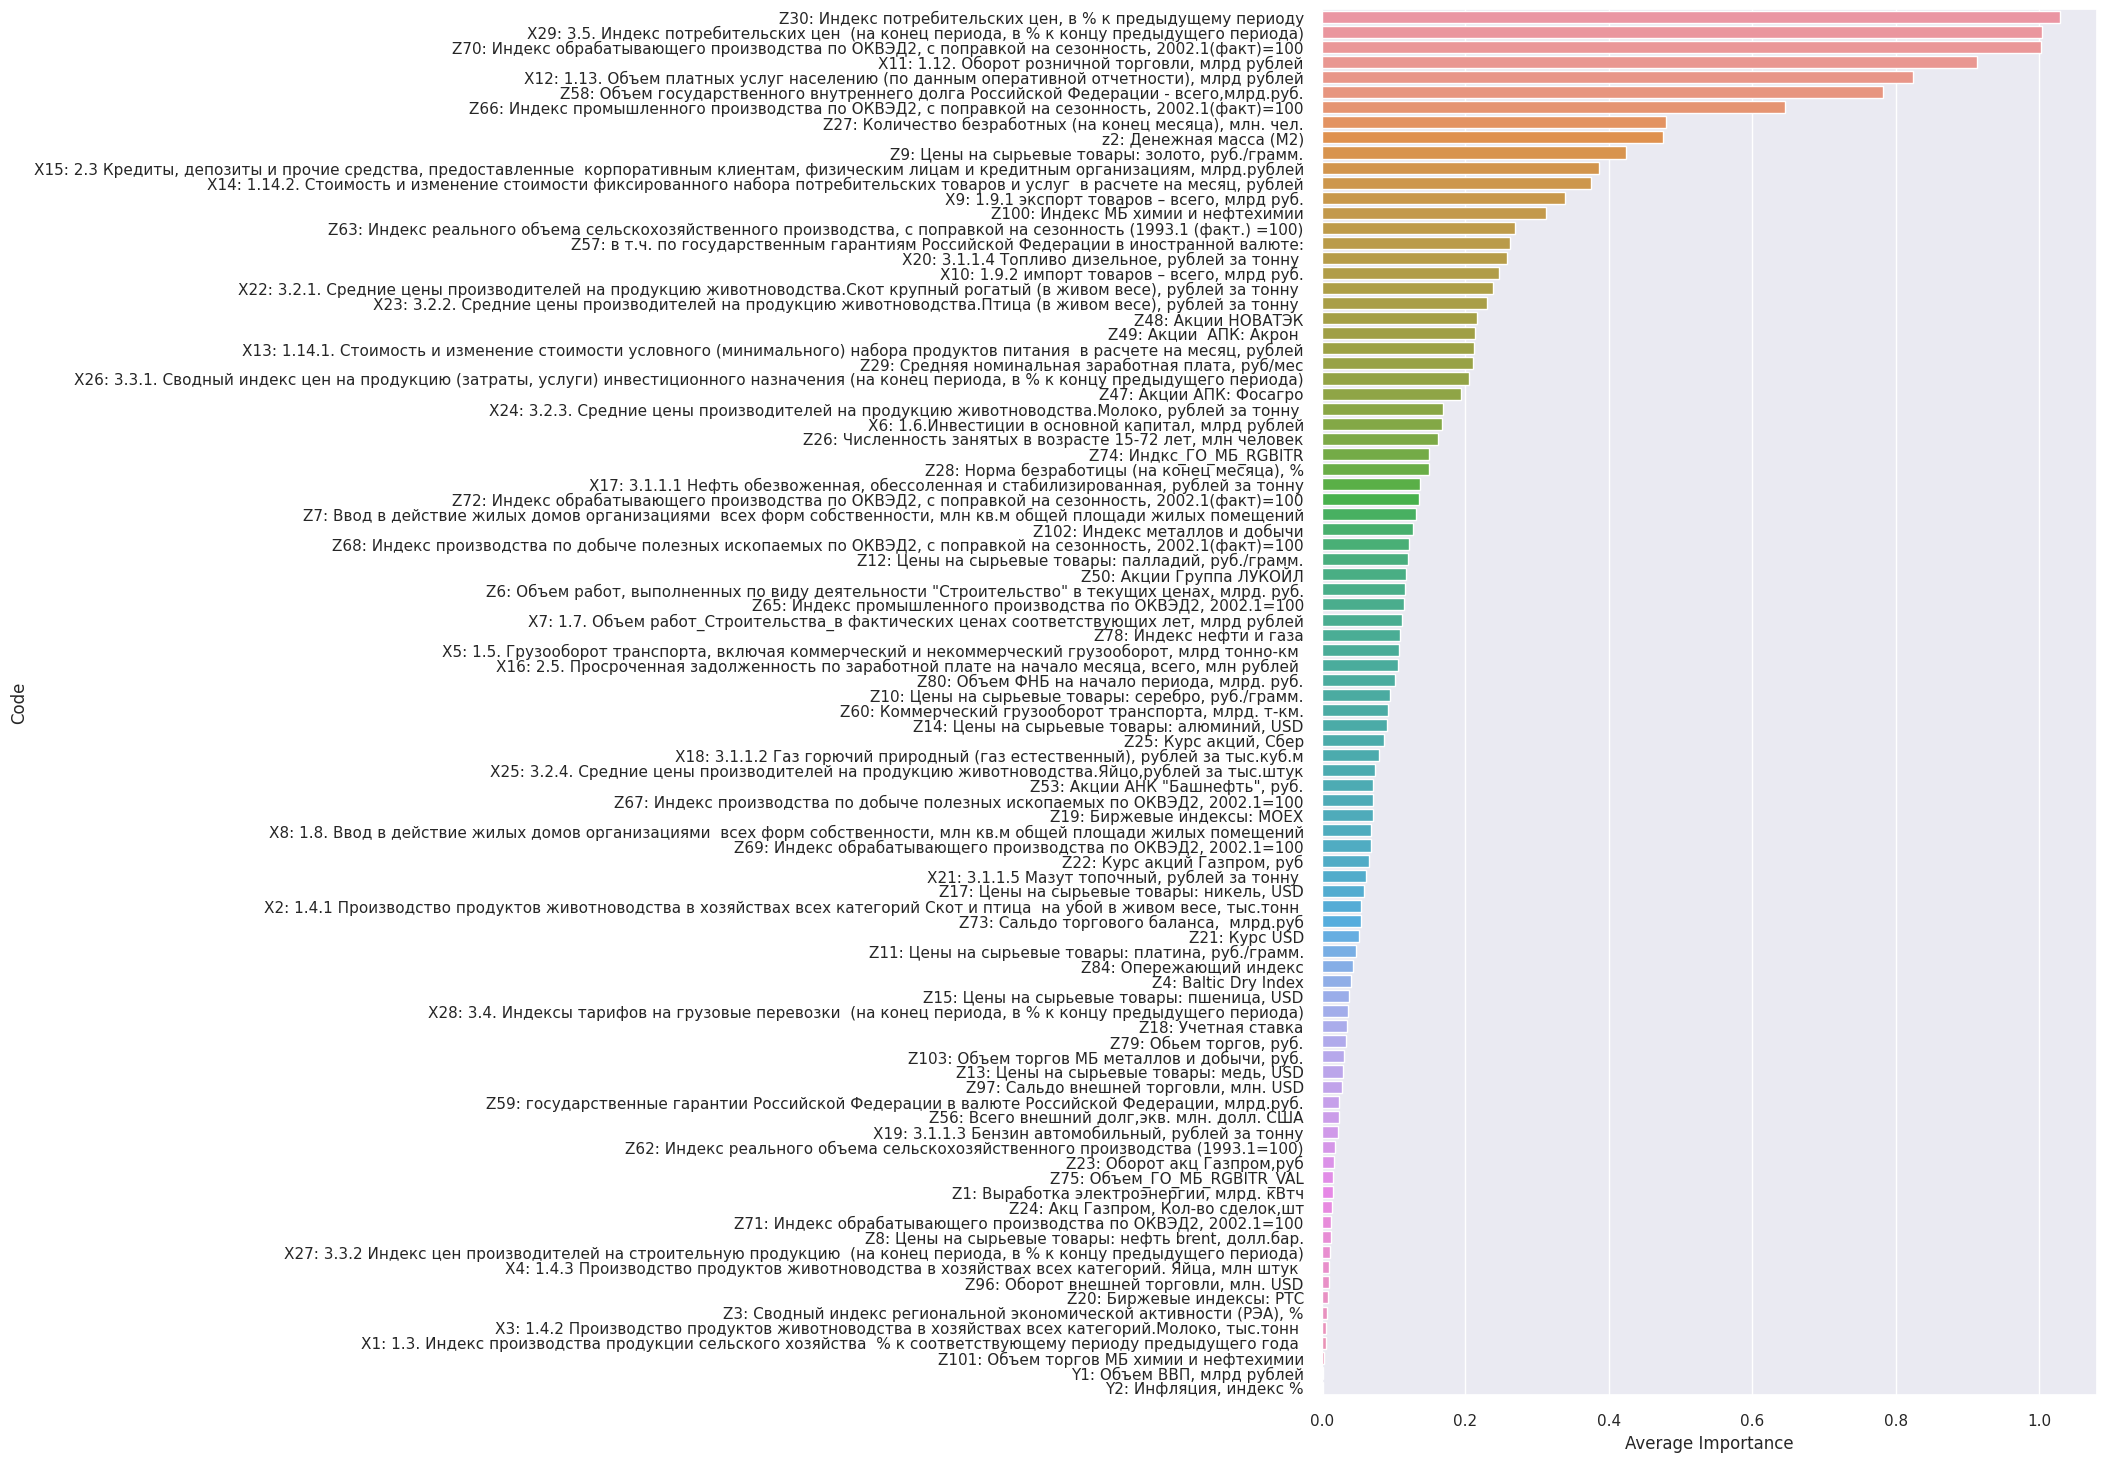

In [ ]:
# Выводим результат на график
sns.set(rc={'figure.figsize':(10, 18)})
sns.barplot(x='Average Importance', y='Code', data=sorted_df)
plt.yticks(range(len(sorted_df['Code'])), [f"{code}: {desc}" for code, desc in zip(sorted_df['Code'], sorted_df['Description'])])
plt.show()


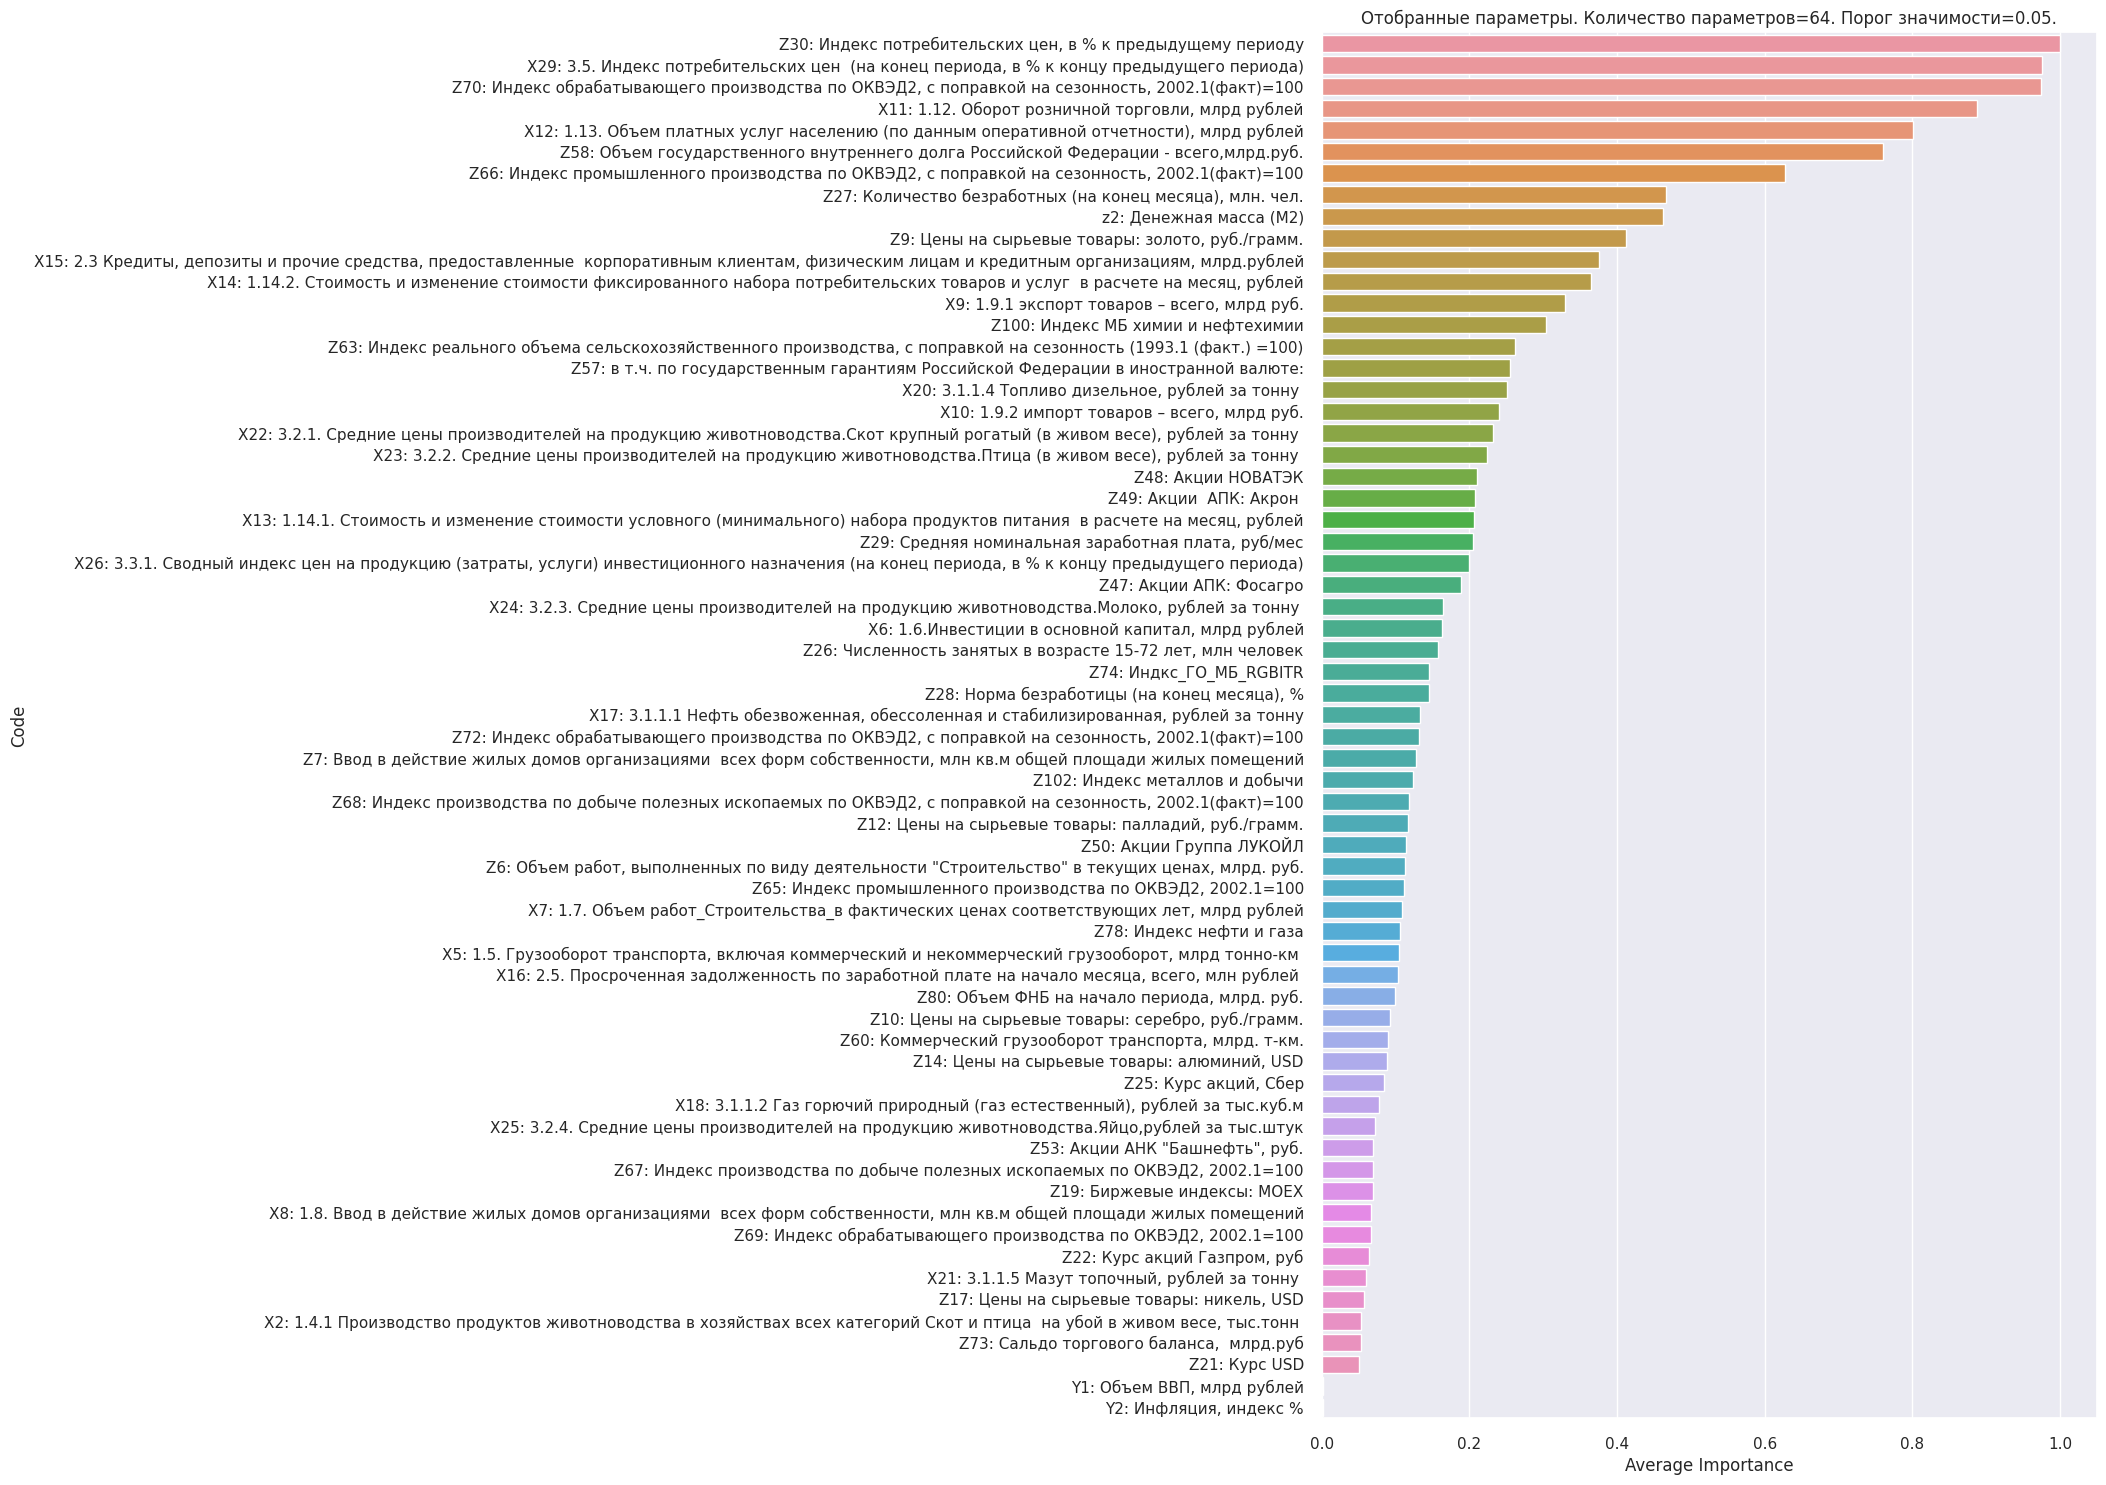

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Importance_merge=0.05

# Отбираем столбцы с рангом значимости выше порога
selected_columns = sorted_df[sorted_df['Average Importance'] > Importance_merge]['Code'].tolist()

# Добавляем столбцы Y1 и Y2 после столбца 'T'
selected_columns.insert(0, 'Y1')
selected_columns.insert(1, 'Y2')

# Создаем датафрейм с отобранными столбцами
selected_df = sorted_df[sorted_df['Code'].isin(selected_columns)]

# Выводим результат на график
sns.set(rc={'figure.figsize':(10, 18)})
sns.barplot(x='Average Importance', y='Code', data=selected_df)
plt.yticks(range(len(selected_df['Code'])), [f"{code}: {desc}" for code, desc in zip(selected_df['Code'], selected_df['Description'])])
plt.title(f'Отобранные параметры. Количество параметров={len(selected_columns)}. Порог значимости={Importance_merge}.')
plt.show()


####8.1.1.2  Подготовка дата сета

In [ ]:
# Создание классов для масштабирование данных
#scaler = MinMaxScaler()
scalerX = StandardScaler()
scalerY = StandardScaler()

In [ ]:
Nparam = 92
#Xin = data.iloc[:, 2:Nparam]  # Входящие данные для ВВП
Xin = data.iloc[:, :]  # Входящие данные для ВВП . Включим в X сами значения прогнозируемых параметров
#Xin = data.iloc[:, :Nparam]  # Входящие данные для ВВП . Включим в X сами значения прогнозируемых параметров

# Оставляем только отобранные столбцы в датафрейме X
Xin = Xin[selected_columns]

Nparam=len(selected_columns)
# Выводим количество оставшихся столбцов
print(f"Количество оставшихся столбцов: {len(selected_columns)}")

# Выводим результат
print(Xin)


yin = data.iloc[:, :2]  # Целевой столбец 1 и 2 ВВП

# Масштабирование данных
scaled_dataX = scalerX.fit_transform(Xin)
scaled_dataY = scalerY.fit_transform(yin)

# Создайте переменную timestamps с временными метками
timestamps = data.index

# Разделите данные и временные метки на обучающие, валидационные и тестовые выборки
X_train_temp, X_temp, y_train_temp, y_temp, index_train_temp, index_temp = train_test_split(
    scaled_dataX, scaled_dataY, timestamps, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test, timestamp_index_val, timestamp_index_test = train_test_split(
    X_temp, y_temp, index_temp, test_size=0.5, shuffle=False)

# Создание датафреймов для обучающей, валидационной и тестовой выборок с учетом временных меток
train_df = pd.DataFrame(y_train_temp, index=index_train_temp, columns=['Y1', 'Y2'])
val_df = pd.DataFrame(y_val, index=timestamp_index_val, columns=['Y1', 'Y2'])
test_df = pd.DataFrame(y_test, index=timestamp_index_test, columns=['Y1', 'Y2'])

train_df_x = pd.DataFrame(X_train_temp, index=index_train_temp, columns=Xin.columns)
val_df_x = pd.DataFrame(X_val, index=timestamp_index_val, columns=Xin.columns)
test_df_x = pd.DataFrame(X_test, index=timestamp_index_test, columns=Xin.columns)


Количество оставшихся столбцов: 64
                      Y1      Y2    Z30    X29    Z70     X11     X12  \
Т                                                                       
2013-01-01   5456.667632  1.0097  101.0  101.0  189.8  1710.7   494.9   
2013-02-01   5456.667632  1.0056  100.6  100.6  189.1  1690.3   504.1   
2013-03-01   5456.667632  1.0034  100.3  100.3  189.0  1840.3   516.8   
2013-04-01   5835.960594  1.0051  100.5  100.5  189.7  1850.3   527.1   
2013-05-01   5835.960594  1.0066  100.7  100.7  191.0  1902.3   525.6   
...                  ...     ...    ...    ...    ...     ...     ...   
2022-08-01  12276.333333  0.9948   99.5   99.5  220.0  3627.2  1085.6   
2022-09-01  12276.333333  1.0005  100.1  100.1  220.8  3532.9  1080.8   
2022-10-01  12700.000000  1.0018  100.2  100.2  221.5  3573.4  1082.0   
2022-11-01  12700.000000  1.0037  100.4  100.4  222.0  3578.2  1096.5   
2022-12-01  12700.000000  1.0078  100.8  100.8  222.2  4201.1  1175.2   

               

####8.1.1.3  Создание модели

In [ ]:
window_size = 12
steps_ahead = 3

X, y = create_dataset_multi_step(scaled_dataX, scaled_dataY, window_size, steps_ahead)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
from tensorflow.keras.layers import Reshape
model = Sequential([
    LSTM(128, input_shape=(window_size, X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
   # LSTM(64, return_sequences= False),
   # Dropout(0.1),
    Dense(2 * steps_ahead),
    Reshape((steps_ahead, 2))
])



#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import ReduceLROnPlateau
initial_learning_rate = 0.001
epochs = 80
# Создаем оптимизатор Adam с начальным значением скорости обучения
#optimizer = Adam(learning_rate=initial_learning_rate)
# Компилируем модель с оптимизатором Adam
#model.compile(optimizer=optimizer, loss='mse')

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               107008    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
 reshape_1 (Reshape)         (None, 3, 2)              0         
                                                                 
Total params: 107,782
Trainable params: 107,782
Non-trainable params: 0
_________________________________________________________________


####8.1.1.4  Обучение модели

In [ ]:
# Калбэк функция для сохранения лучших моделей
import os
from tensorflow.keras.callbacks import Callback
class SaveBestModelWithValLoss(Callback):
    def __init__(self, output_dir):
        super().__init__()
        self.output_dir = output_dir
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            model_path = os.path.join(self.output_dir, f"best_model_epoch_{epoch}_val_loss_{val_loss:.5f}.h5")
            self.model.save(model_path)
            print(f"Model saved as {model_path}")

# Создайте экземпляр класса SaveBestModelWithValLoss
save_best_model_with_val_loss = SaveBestModelWithValLoss(output_dir="models1")

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)



In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=40, batch_size=1, validation_data=(X_val, y_val), callbacks=[early_stopping])
#history = model.fit(X_train, y_train, epochs=40, batch_size=1, validation_data=(X_val, y_val))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
model_checkpoint = ModelCheckpoint('best_model_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)


history = model.fit(X_train, y_train, epochs=80, batch_size=1, validation_data=(X_val, y_val), callbacks=[ model_checkpoint, save_best_model_with_val_loss])
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_val, y_val), callbacks=[reduce_lr, model_checkpoint, save_best_model_with_val_loss])

model.load_weights('best_model_.h5')


Epoch 1/80
79/84 [===========================>..] - ETA: 0s - loss: 0.3553
Epoch 1: val_loss improved from inf to 0.62489, saving model to best_model_.h5
Model saved as models1/best_model_epoch_0_val_loss_0.62489.h5
84/84 [==============================] - 3s 9ms/step - loss: 0.3485 - val_loss: 0.6249
Epoch 2/80
77/84 [==========================>...] - ETA: 0s - loss: 0.2145
Epoch 2: val_loss did not improve from 0.62489
84/84 [==============================] - 0s 4ms/step - loss: 0.2075 - val_loss: 0.6977
Epoch 3/80
78/84 [==========================>...] - ETA: 0s - loss: 0.1557
Epoch 3: val_loss improved from 0.62489 to 0.44735, saving model to best_model_.h5
Model saved as models1/best_model_epoch_2_val_loss_0.44735.h5
84/84 [==============================] - 0s 4ms/step - loss: 0.1514 - val_loss: 0.4473
Epoch 4/80
73/84 [=========================>....] - ETA: 0s - loss: 0.1274
Epoch 4: val_loss did not improve from 0.44735
84/84 [==============================] - 0s 4ms/step - loss

In [ ]:
#!cp /content/best_model.h5  drive/MyDrive/Стажировка_РАН/best_model_Par80_0_137.h5

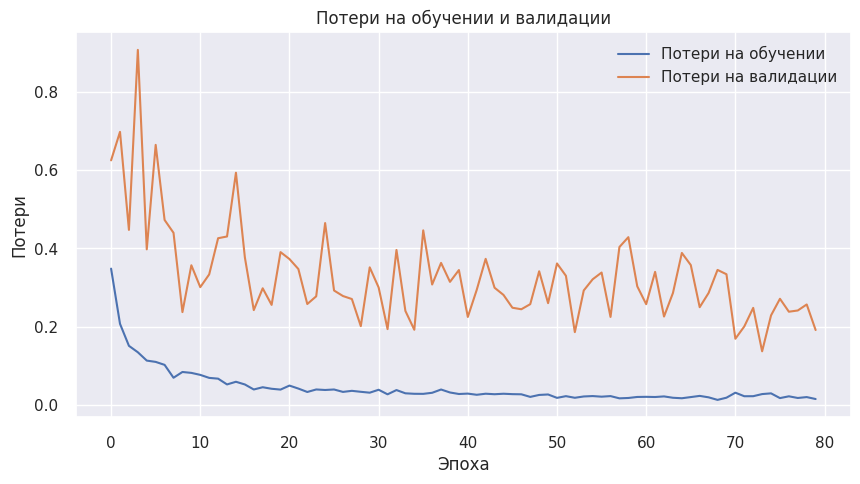

In [ ]:
# Вывод графика результатов обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.title('Потери на обучении и валидации')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

# 2. Загрузка сохраненной модели
#best_model = tf.keras.models.load_model('best_model.h5')
# 2. Загрузка весов сохраненной модели
model.load_weights('best_model_.h5')
#model.load_weights('best_model_finetuned_.h5')
# 3. Обучение загруженной модели с меньшим значением скорости обучения
finetune_learning_rate = 0.0003
optimizer_finetune = Adam(learning_rate=finetune_learning_rate)
model.compile(optimizer=optimizer_finetune, loss='mse')

# Callback для сохранения модели с лучшими потерями на валидации во время дообучения
model_checkpoint_finetune = ModelCheckpoint('best_model_finetuned_.h5', monitor='val_loss', save_best_only=True)
epochs=160
# Дообучение модели
history_finetune = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_finetune])

Epoch 1/160
84/84 [==============================] - 3s 9ms/step - loss: 0.0177 - val_loss: 0.1523
Epoch 2/160
84/84 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.1498
Epoch 3/160
84/84 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.2000
Epoch 4/160
84/84 [==============================] - 0s 4ms/step - loss: 0.0128 - val_loss: 0.1826
Epoch 5/160
84/84 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.2147
Epoch 6/160
84/84 [==============================] - 1s 6ms/step - loss: 0.0120 - val_loss: 0.1898
Epoch 7/160
84/84 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.2203
Epoch 8/160
84/84 [==============================] - 1s 8ms/step - loss: 0.0217 - val_loss: 0.1847
Epoch 9/160
84/84 [==============================] - 1s 8ms/step - loss: 0.0129 - val_loss: 0.2015
Epoch 10/160
84/84 [==============================] - 1s 10ms/step - loss: 0.0163 - val_loss: 0.1977
Epoch 11

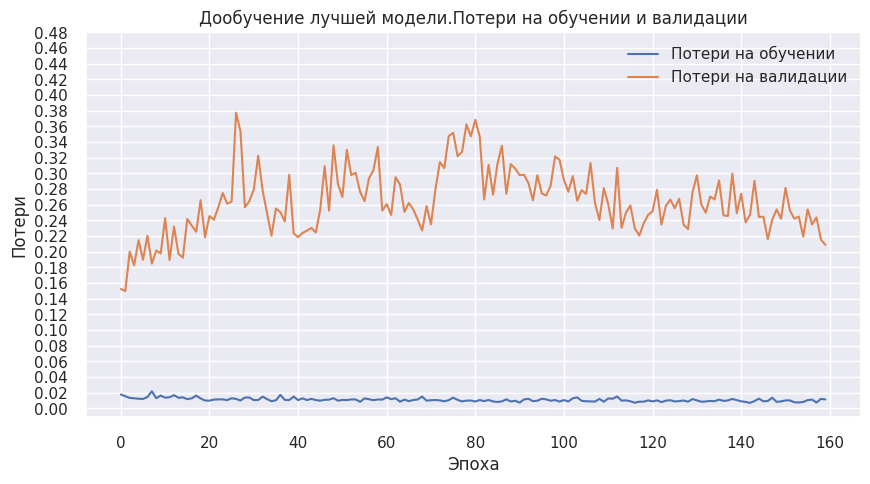

In [ ]:
# Вывод графика результатов обучения
plt.figure(figsize=(10, 5))
plt.plot(history_finetune.history['loss'], label='Потери на обучении')
plt.plot(history_finetune.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
# Задаем шаг для оси Y
y_ticks = np.arange(0, 0.5, 0.02)
plt.yticks(y_ticks)
plt.legend()
plt.title('Дообучение лучшей модели.Потери на обучении и валидации')
plt.show()

In [ ]:
#!cp /content/best_model_finetuned.h5  drive/MyDrive/Стажировка_РАН/best_model_Par80_0_15.h5

####8.1.1.5  Вывод графиков прогноза

1/1 [==============================] - 0s 19ms/step


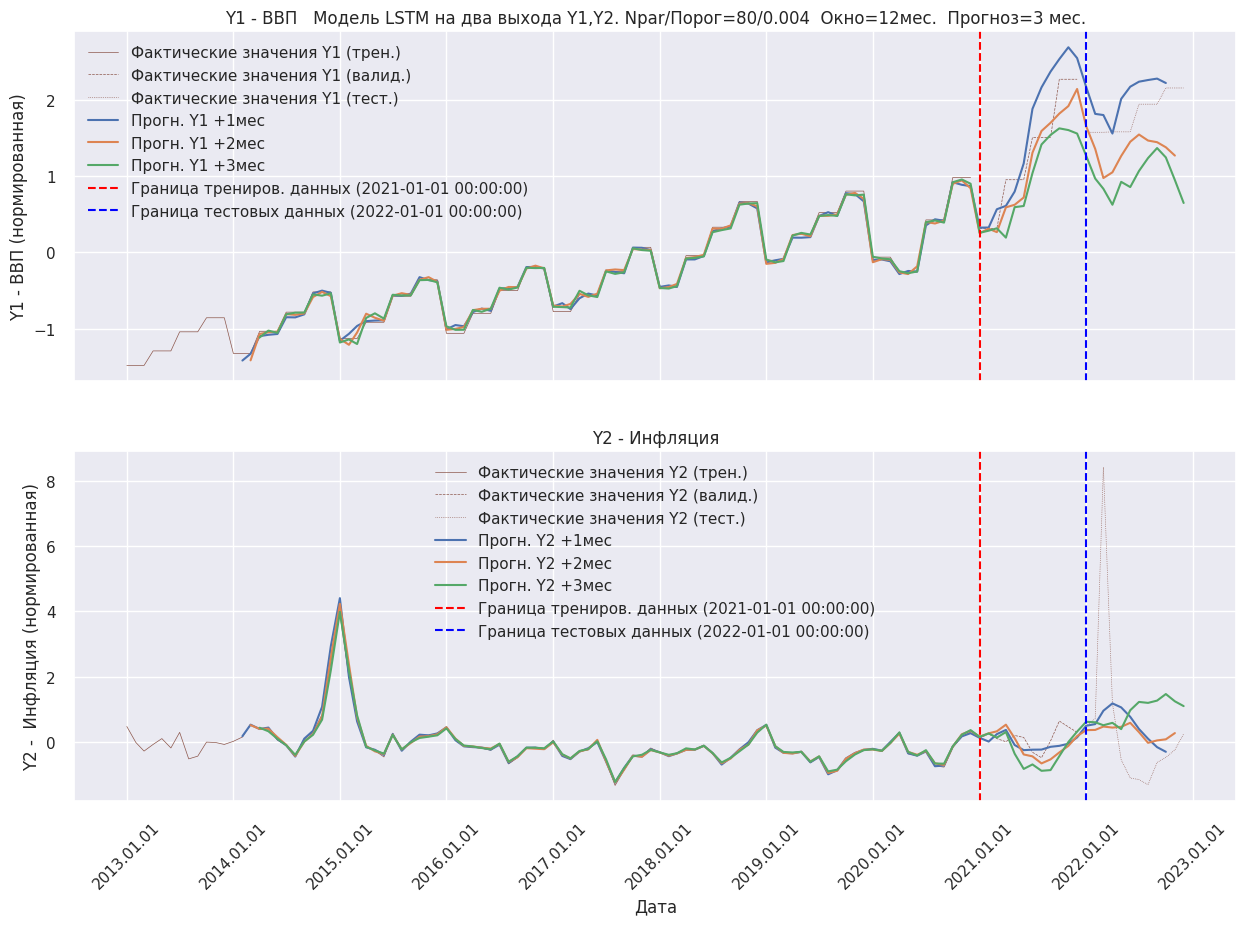

In [ ]:
#"Графики прогнозов"

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_multistep(model, X_input):
    predictions = model.predict(X_input[np.newaxis, ...])
    return predictions[0].reshape(-1, 2)

# Объедините все массивы временных меток и данные Y
# timestamps   - временные метки всего массива
# Создайте переменную timestamps с временными метками только для данных X
#timestamps = timestamps[:len(X)]
#all_Y = np.concatenate((y_train_temp, y_val, y_test))

# Получить прогнозы для всех данных
all_predictions = np.array([predict_multistep(model, x) for x in X])

# Разделить прогнозы на Y1 и Y2
predicted_Y1 = all_predictions[:, :, 0]
predicted_Y2 = all_predictions[:, :, 1]

# Разделить истинные значения на Y1 и Y2
true_Y1 = y[:,:, 0]
true_Y2 = y[:,:, 1]

# Создать график
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
#ax1.plot(timestamps[window_size+1:-2], true_Y1[:,0],linestyle='dotted', label='True Y1')
ax1.plot(train_df.index, train_df['Y1'],linewidth=0.5, color=color, label='Фактические значения Y1 (трен.)')
ax1.plot(val_df.index, val_df['Y1'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y1 (валид.)')
ax1.plot(test_df.index, test_df['Y1'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y1 (тест.)')

ax1.plot(timestamps[window_size+1:-2], predicted_Y1[:,0], label='Прогн. Y1 +1мес')
ax1.plot(timestamps[window_size+2:-1], predicted_Y1[:,1], label='Прогн. Y1 +2мес')
ax1.plot(timestamps[window_size+3:], predicted_Y1[:,2], label='Прогн. Y1 +3мес')
ax1.set_title(f'Y1 - ВВП   Модель LSTM на два выхода Y1,Y2. Npar/Порог={Nparam}/{Importance_merge}  Окно={window_size}мес.  Прогноз={steps_ahead} мес.')
 
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax1.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax1.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax1.legend()
ax1.set_ylabel("Y1 - ВВП (нормированная)")
# График истинных значений и прогнозов для Y2
# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
ax2.plot(train_df.index, train_df['Y2'],linewidth=0.5, color=color, label='Фактические значения Y2 (трен.)')
ax2.plot(val_df.index, val_df['Y2'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y2 (валид.)')
ax2.plot(test_df.index, test_df['Y2'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y2 (тест.)')

#ax2.plot(timestamps[window_size:-3], true_Y2[:,0], label='True Y2')
ax2.plot(timestamps[window_size+1:-2], predicted_Y2[:,0], label='Прогн. Y2 +1мес')
ax2.plot(timestamps[window_size+2:-1], predicted_Y2[:,1], label='Прогн. Y2 +2мес')
ax2.plot(timestamps[window_size+3:], predicted_Y2[:,2], label='Прогн. Y2 +3мес')
ax2.set_title('Y2 - Инфляция')
ax2.set_ylabel("Y2 -  Инфляция (нормированная)")
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax2.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax2.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax2.legend()

plt.xlabel('Дата')
plt.xticks(rotation=45)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()


###8.1.2 LSTM модель на два выхода для ВВП и инфляции. Вариант 2

####8.1.2.1  Создание модели Вариант 2

In [ ]:
window_size = 12
steps_ahead = 3

X, y = create_dataset_multi_step(scaled_dataX, scaled_dataY, window_size, steps_ahead)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.models import Model
# Создание входного слоя
input_layer = Input(shape=(12, 80), name='input_1')

# Слой LSTM 1
lstm_layer1 = LSTM(units=80, return_sequences=True, activation='relu')(input_layer)
dropout_layer1 = Dropout(rate=0.4)(lstm_layer1)
# Слой LSTM 2
lstm_layer2 = LSTM(units=80, return_sequences=True, activation='relu')(dropout_layer1)
# Dropout слой
dropout_layer = Dropout(rate=0.4)(lstm_layer2)
# Слой LSTM 3
lstm_layer3 = LSTM(units=80, activation='relu')(dropout_layer)
dropout_layer3 = Dropout(rate=0.4)(lstm_layer3)
# Слой Flatten
flatten_layer = Flatten()(dropout_layer3)
# Полносвязный слой
dense_layer = Dense(units=6, activation='relu')(flatten_layer)
# Слой Reshape
output_layer = Reshape(target_shape=(3, 2))(dense_layer)
# Создание модели
model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
"""
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Reshape, Dropout, Lambda, BatchNormalization, TimeDistributed, RepeatVector, Concatenate
from tensorflow.keras.models import Model
#import autokeras as ak

# Создание входного слоя
input_layer = Input(shape=(12, 80), name='input_1')
# Слой LSTM
lstm_layer = LSTM(units=32, return_sequences=True)(input_layer)
# Слой Flatten
flatten_layer = Flatten()(lstm_layer)
flatten_layer = Dropout(rate=0.35)(flatten_layer)
# Полносвязный слой
dense_layer = Dense(units=6)(flatten_layer)
# Слой Reshape
output_layer = Reshape(target_shape=(3, 2))(dense_layer)
# Выходной слой
#output_layer = Dense(units=2, name='output')(flatten_layer_1)

# Создание модели
model = Model(inputs=input_layer, outputs=output_layer)
"""

"\nfrom tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Reshape, Dropout, Lambda, BatchNormalization, TimeDistributed, RepeatVector, Concatenate\nfrom tensorflow.keras.models import Model\n#import autokeras as ak\n\n# Создание входного слоя\ninput_layer = Input(shape=(12, 80), name='input_1')\n# Слой LSTM\nlstm_layer = LSTM(units=32, return_sequences=True)(input_layer)\n# Слой Flatten\nflatten_layer = Flatten()(lstm_layer)\nflatten_layer = Dropout(rate=0.35)(flatten_layer)\n# Полносвязный слой\ndense_layer = Dense(units=6)(flatten_layer)\n# Слой Reshape\noutput_layer = Reshape(target_shape=(3, 2))(dense_layer)\n# Выходной слой\n#output_layer = Dense(units=2, name='output')(flatten_layer_1)\n\n# Создание модели\nmodel = Model(inputs=input_layer, outputs=output_layer)\n"

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 80)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 80)            51520     
                                                                 
 dropout_2 (Dropout)         (None, 12, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 12, 80)            51520     
                                                                 
 dropout_3 (Dropout)         (None, 12, 80)            0         
                                                                 
 lstm_4 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_4 (Dropout)         (None, 80)                0     

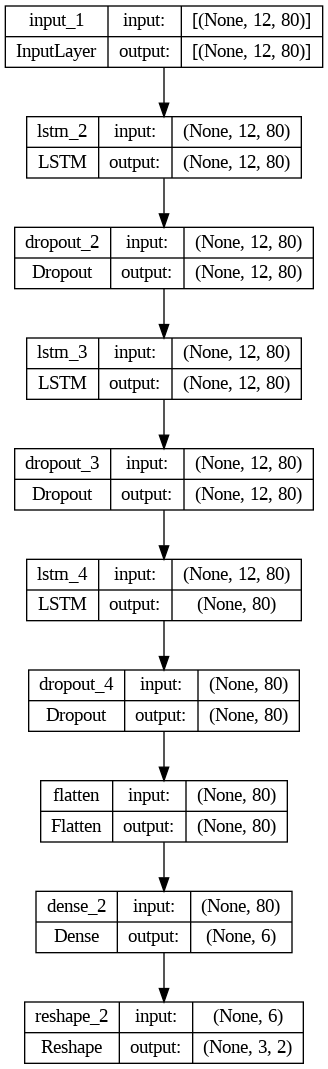

In [ ]:
# Компиляция модели
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.003, decay=0.0051)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
# Вывод информации о модели
model.summary()
from tensorflow.keras.utils import plot_model
# Сохранение схемы модели в файл
plot_model(model, to_file=f"model_p80_var2__structure.png", show_shapes=True, show_layer_names=True)


In [ ]:
"""
from tensorflow.keras.layers import Reshape
model = Sequential([
    LSTM(128, input_shape=(window_size, X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
   # LSTM(64, return_sequences= False),
   # Dropout(0.1),
    Dense(2 * steps_ahead),
    Reshape((steps_ahead, 2))
])
"""

#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import ReduceLROnPlateau
initial_learning_rate = 0.001
epochs = 80
# Создаем оптимизатор Adam с начальным значением скорости обучения
#optimizer = Adam(learning_rate=initial_learning_rate)
# Компилируем модель с оптимизатором Adam
#model.compile(optimizer=optimizer, loss='mse')
optimizer = Adam(learning_rate=0.001, decay=0.0051)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

#model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 80)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 80)            51520     
                                                                 
 dropout_2 (Dropout)         (None, 12, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 12, 80)            51520     
                                                                 
 dropout_3 (Dropout)         (None, 12, 80)            0         
                                                                 
 lstm_4 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_4 (Dropout)         (None, 80)                0     

####8.1.2.2  Обучение модели

In [ ]:
# Калбэк функция для сохранения лучших моделей
import os
from tensorflow.keras.callbacks import Callback
class SaveBestModelWithValLoss(Callback):
    def __init__(self, output_dir):
        super().__init__()
        self.output_dir = output_dir
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            model_path = os.path.join(self.output_dir, f"best_model_epoch_{epoch}_val_loss_{val_loss:.5f}.h5")
            self.model.save(model_path)
            print(f"Model saved as {model_path}")

# Создайте экземпляр класса SaveBestModelWithValLoss
save_best_model_with_val_loss = SaveBestModelWithValLoss(output_dir="models1")

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)



In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=40, batch_size=1, validation_data=(X_val, y_val), callbacks=[early_stopping])
#history = model.fit(X_train, y_train, epochs=40, batch_size=1, validation_data=(X_val, y_val))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
model_checkpoint = ModelCheckpoint('best_model_.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)


history = model.fit(X_train, y_train, epochs=1000, batch_size=1, validation_data=(X_val, y_val), callbacks=[ model_checkpoint, save_best_model_with_val_loss])
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_val, y_val), callbacks=[reduce_lr, model_checkpoint, save_best_model_with_val_loss])

model.load_weights('best_model_.h5')


Epoch 1/1000
83/84 [============================>.] - ETA: 0s - loss: 0.4449 - mse: 0.4449
Epoch 1: val_loss improved from inf to 1.24080, saving model to best_model_.h5
Model saved as models1/best_model_epoch_0_val_loss_1.24080.h5
84/84 [==============================] - 5s 36ms/step - loss: 0.4428 - mse: 0.4428 - val_loss: 1.2408 - val_mse: 1.2408
Epoch 2/1000
84/84 [==============================] - ETA: 0s - loss: 0.4925 - mse: 0.4925
Epoch 2: val_loss improved from 1.24080 to 0.68727, saving model to best_model_.h5
Model saved as models1/best_model_epoch_1_val_loss_0.68727.h5
84/84 [==============================] - 3s 39ms/step - loss: 0.4925 - mse: 0.4925 - val_loss: 0.6873 - val_mse: 0.6873
Epoch 3/1000
84/84 [==============================] - ETA: 0s - loss: 0.4334 - mse: 0.4334
Epoch 3: val_loss did not improve from 0.68727
84/84 [==============================] - 3s 41ms/step - loss: 0.4334 - mse: 0.4334 - val_loss: 0.7778 - val_mse: 0.7778
Epoch 4/1000
83/84 [==============

KeyboardInterrupt: ignored

In [ ]:
!cp /content/best_model.h5  drive/MyDrive/Стажировка_РАН/best_model_Par80_ValLoss_0_137xxx.h5

In [ ]:
# 2. Загрузка весов сохраненной модели
model.load_weights('best_model_.h5')

In [ ]:
# Вывод графика результатов обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.title('Потери на обучении и валидации')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam

# 2. Загрузка сохраненной модели
#best_model = tf.keras.models.load_model('best_model.h5')
# 2. Загрузка весов сохраненной модели
model.load_weights('best_model_.h5')
#model.load_weights('best_model_finetuned_.h5')
# 3. Обучение загруженной модели с меньшим значением скорости обучения
finetune_learning_rate = 0.0003
optimizer_finetune = Adam(learning_rate=finetune_learning_rate)
model.compile(optimizer=optimizer_finetune, loss='mse')

# Callback для сохранения модели с лучшими потерями на валидации во время дообучения
model_checkpoint_finetune = ModelCheckpoint('best_model_finetuned_.h5', monitor='val_loss', save_best_only=True)
epochs=160
# Дообучение модели
history_finetune = model.fit(X_train, y_train, epochs=epochs, batch_size=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_finetune])

In [ ]:
# Вывод графика результатов обучения
plt.figure(figsize=(10, 5))
plt.plot(history_finetune.history['loss'], label='Потери на обучении')
plt.plot(history_finetune.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
# Задаем шаг для оси Y
y_ticks = np.arange(0, 0.5, 0.02)
plt.yticks(y_ticks)
plt.legend()
plt.title('Дообучение лучшей модели.Потери на обучении и валидации')
plt.show()

In [ ]:
#!cp /content/best_model_finetuned.h5  drive/MyDrive/Стажировка_РАН/best_model_Par80_0_128xx.h5

####8.1.2.3  Вывод графиков прогноза

1/1 [==============================] - 0s 23ms/step


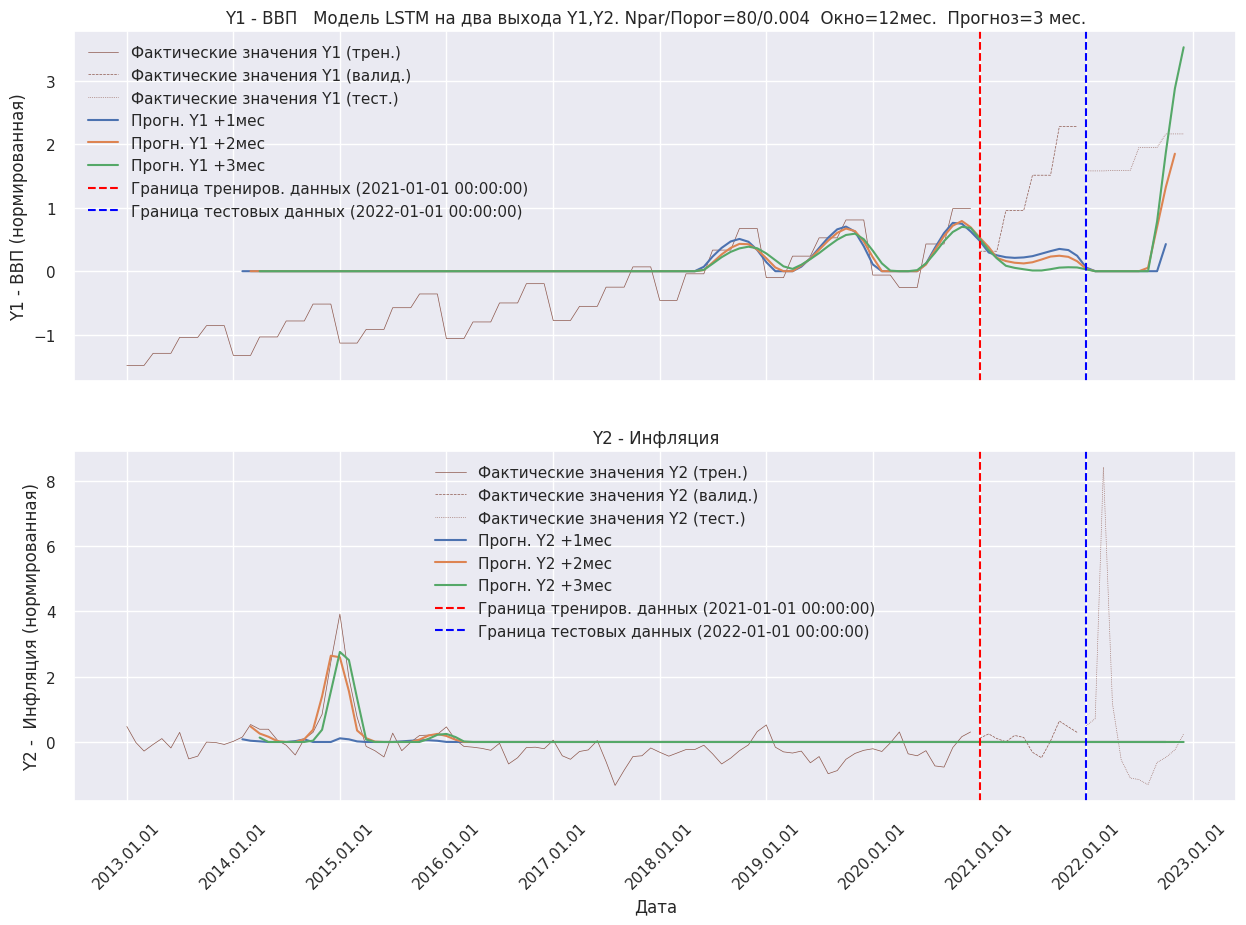

In [ ]:
#"Графики прогнозов"

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_multistep(model, X_input):
    predictions = model.predict(X_input[np.newaxis, ...])
    return predictions[0].reshape(-1, 2)

# Объедините все массивы временных меток и данные Y
# timestamps   - временные метки всего массива
# Создайте переменную timestamps с временными метками только для данных X
#timestamps = timestamps[:len(X)]
#all_Y = np.concatenate((y_train_temp, y_val, y_test))

# Получить прогнозы для всех данных
all_predictions = np.array([predict_multistep(model, x) for x in X])

# Разделить прогнозы на Y1 и Y2
predicted_Y1 = all_predictions[:, :, 0]
predicted_Y2 = all_predictions[:, :, 1]

# Разделить истинные значения на Y1 и Y2
true_Y1 = y[:,:, 0]
true_Y2 = y[:,:, 1]

# Создать график
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
#ax1.plot(timestamps[window_size+1:-2], true_Y1[:,0],linestyle='dotted', label='True Y1')
ax1.plot(train_df.index, train_df['Y1'],linewidth=0.5, color=color, label='Фактические значения Y1 (трен.)')
ax1.plot(val_df.index, val_df['Y1'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y1 (валид.)')
ax1.plot(test_df.index, test_df['Y1'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y1 (тест.)')

ax1.plot(timestamps[window_size+1:-2], predicted_Y1[:,0], label='Прогн. Y1 +1мес')
ax1.plot(timestamps[window_size+2:-1], predicted_Y1[:,1], label='Прогн. Y1 +2мес')
ax1.plot(timestamps[window_size+3:], predicted_Y1[:,2], label='Прогн. Y1 +3мес')
ax1.set_title(f'Y1 - ВВП   Модель LSTM на два выхода Y1,Y2. Npar/Порог={Nparam}/{Importance_merge}  Окно={window_size}мес.  Прогноз={steps_ahead} мес.')
 
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax1.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax1.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax1.legend()
ax1.set_ylabel("Y1 - ВВП (нормированная)")
# График истинных значений и прогнозов для Y2
# График истинных значений и прогнозов для Y1
color = 'tab:brown'
color_val = 'tab:green'
ax2.plot(train_df.index, train_df['Y2'],linewidth=0.5, color=color, label='Фактические значения Y2 (трен.)')
ax2.plot(val_df.index, val_df['Y2'], linewidth=0.5,color=color,linestyle='dashed', label='Фактические значения Y2 (валид.)')
ax2.plot(test_df.index, test_df['Y2'], linewidth=0.5,color=color,linestyle='dotted', label='Фактические значения Y2 (тест.)')

#ax2.plot(timestamps[window_size:-3], true_Y2[:,0], label='True Y2')
ax2.plot(timestamps[window_size+1:-2], predicted_Y2[:,0], label='Прогн. Y2 +1мес')
ax2.plot(timestamps[window_size+2:-1], predicted_Y2[:,1], label='Прогн. Y2 +2мес')
ax2.plot(timestamps[window_size+3:], predicted_Y2[:,2], label='Прогн. Y2 +3мес')
ax2.set_title('Y2 - Инфляция')
ax2.set_ylabel("Y2 -  Инфляция (нормированная)")
# Граница между прогнозом и данными
split_date = val_df.index[0]
ax2.axvline(x=split_date, color='red', linestyle='--', label=f'Граница трениров. данных ({split_date})')
# Граница между прогнозом и данными
split_date = test_df.index[0]
ax2.axvline(x=split_date, color='blue', linestyle='--', label=f'Граница тестовых данных ({split_date})')
ax2.legend()

plt.xlabel('Дата')
plt.xticks(rotation=45)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.show()
